# Decision Trees
# Trees Ensemble

 In this notebook, you will:

 - Use Pandas to perform one-hot encoding of a dataset
 - Use scikit-learn to implement a Decision Tree, Random Forest and XGBoost models

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv
/kaggle/input/matplotlib-style/matplotlib.mplstyle


Let's import the libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
plt.style.use('/kaggle/input/matplotlib-style/matplotlib.mplstyle')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

RANDOM_STATE = 55 ## We will pass it to every sklearn call so we ensure reproducibility

# 1. Introduction
## Datatset
This dataset is obtained from Kaggle: Heart Failure Prediction Dataset

## Context
*     Cardiovascular disease (CVDs) is the number one cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of five CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs.
*     People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management.
*     This dataset contains 11 features that can be used to predict possible heart disease.
*     Let's train a machine learning model to assist with diagnosing this disease.

## Attribute Information
1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]

Let's now load the dataset. As we can see above, the variables:

* Sex
* ChestPainType
* RestingECG
* ExerciseAngina
* ST_Slope

Are categorical, so we must one-hot encode them.

In [3]:
df = pd.read_csv('/kaggle/input/heart-failure-prediction/heart.csv')

In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


We must perform some data engineering before working with the models. There are 5 categorical features, so we will use Pandas to one-hot encode them.

## 2. One-hot encoding using Pandas

First we will remove the binary variables, because one-hot encoding them would do nothing to them. To achieve this we will just count how many different values there are in each categorical variable and consider only the variables with 3 or more values.

In [5]:
cat_variables = ['Sex',
'ChestPainType',
'RestingECG',
'ExerciseAngina',
'ST_Slope'
]

As a reminder, one-hot encoding aims to transform a categorical variable with `n` outputs into `n` binary variables.

Pandas has a built-in method to one-hot encode variables, it is the function `pd.get_dummies`. There are several arguments to this function, but here we will use only a few. They are:

 - data: DataFrame to be used
 - prefix: A list with prefixes, so we know which value we are dealing with
 - columns: the list of columns that will be one-hot encoded. 'prefix' and 'columns' must have the same length.
 
For more information, you can always type `help(pd.get_dummies)` to read the function's full documentation.

In [6]:
# This will replace the columns with the one-hot encoded ones and keep the columns outside 'columns' argument as it is.
df = pd.get_dummies(data = df,
                         prefix = cat_variables,
                         columns = cat_variables)

In [7]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,False,True,False,...,False,False,False,True,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,True,False,False,...,True,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,False,True,False,...,False,False,False,False,True,True,False,False,False,True
3,48,138,214,0,108,1.5,1,True,False,True,...,False,False,False,True,False,False,True,False,True,False
4,54,150,195,0,122,0.0,0,False,True,False,...,True,False,False,True,False,True,False,False,False,True


Let's choose the variables that will be the input features of the model.
- The target is `HeartDisease`.
- All other variables are features that can potentially be used to predict the target, `HeartDisease`.

In [8]:

features = [x for x in df.columns if x not in 'HeartDisease'] ## Removing our target variable
features
len(features)

['Age',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'MaxHR',
 'Oldpeak',
 'Sex_F',
 'Sex_M',
 'ChestPainType_ASY',
 'ChestPainType_ATA',
 'ChestPainType_NAP',
 'ChestPainType_TA',
 'RestingECG_LVH',
 'RestingECG_Normal',
 'RestingECG_ST',
 'ExerciseAngina_N',
 'ExerciseAngina_Y',
 'ST_Slope_Down',
 'ST_Slope_Flat',
 'ST_Slope_Up']

20

# 3. Splitting the Dataset

In this section, we will split our dataset into train and test datasets. We will use the function `train_test_split` from Scikit-learn. Let's just check its arguments.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(df[features], df['HeartDisease'], train_size = 0.8, random_state = RANDOM_STATE)

# We will keep the shuffle = True since our dataset has not any time dependency.

In [10]:
print(f'train samples: {len(X_train)}')
print(f'validation samples: {len(X_val)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

train samples: 734
validation samples: 184
target proportion: 0.5518


# 4. Building the Models

## 4.1 Decision Tree

In this section, let's work with the Decision using the [Scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). 

There are several hyperparameters in the Decision Tree object from Scikit-learn. We will use only some of them and also we will not perform feature selection nor hyperparameter tuning here (you are encouraged to do so and compare the results 😄 )

The hyperparameters we will use and investigate here are:

 - min_samples_split: The minimum number of samples required to split an internal node. 
   - Choosing a higher min_samples_split can reduce the number of splits and may help to reduce overfitting.
 - max_depth: The maximum depth of the tree. 
   - Choosing a lower max_depth can reduce the number of splits and may help to reduce overfitting.

In [11]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.

In [12]:
accuracy_list_train=[]
accuracy_list_val=[]
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(min_samples_split=min_samples_split, random_state=RANDOM_STATE)
    model.fit(X_train,y_train)
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_list_train.append(accuracy_score(predictions_train,y_train))
    accuracy_list_val.append(accuracy_score(predictions_val, y_val))
    

accuracy_list_train
accuracy_list_val


DecisionTreeClassifier(random_state=55)

DecisionTreeClassifier(min_samples_split=10, random_state=55)

DecisionTreeClassifier(min_samples_split=30, random_state=55)

DecisionTreeClassifier(min_samples_split=50, random_state=55)

DecisionTreeClassifier(min_samples_split=100, random_state=55)

DecisionTreeClassifier(min_samples_split=200, random_state=55)

DecisionTreeClassifier(min_samples_split=300, random_state=55)

DecisionTreeClassifier(min_samples_split=700, random_state=55)

[1.0,
 0.9455040871934605,
 0.8910081743869209,
 0.8719346049046321,
 0.8501362397820164,
 0.8188010899182562,
 0.8106267029972752,
 0.8106267029972752]

[0.8097826086956522,
 0.8043478260869565,
 0.8478260869565217,
 0.8478260869565217,
 0.8369565217391305,
 0.8260869565217391,
 0.8260869565217391,
 0.8260869565217391]

Text(0.5, 1.0, 'Train x Validations metrics')

Text(0.5, 0, 'min_sample_split')

Text(0, 0.5, 'accuracy')

range(0, 8)

([<matplotlib.axis.XTick at 0x7e126fac27a0>,
 [Text(0, 0, '2'),
  Text(1, 0, '10'),
  Text(2, 0, '30'),
  Text(3, 0, '50'),
  Text(4, 0, '100'),
  Text(5, 0, '200'),
  Text(6, 0, '300'),
  Text(7, 0, '700')])

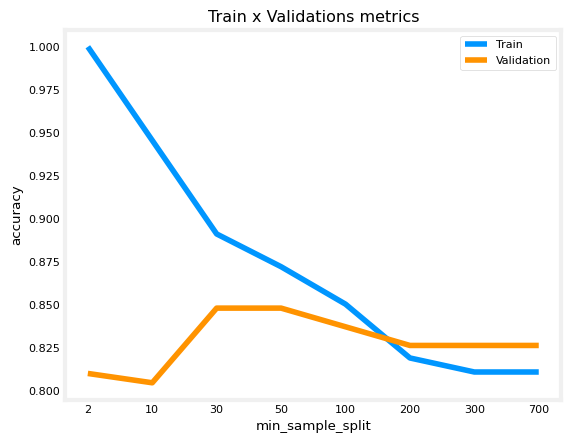

In [13]:
plt.title('Train x Validations metrics')
plt.xlabel('min_sample_split')
plt.ylabel('accuracy')
range(len(min_samples_split_list))
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Validation'])


Note how increasing the the number of `min_samples_split` reduces overfitting.
- Increasing `min_samples_split` from 10 to 30, and from 30 to 50, even though it does not improve the validation accuracy, it brings the training accuracy closer to it, showing a reduction in overfitting.

Let's do the same experiment with `max_depth`.

In [14]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE)
    model.fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_list_train.append(accuracy_score(predictions_train,y_train))
    accuracy_list_val.append(accuracy_score(predictions_val, y_val))
    

accuracy_list_train
accuracy_list_val

DecisionTreeClassifier(max_depth=1, random_state=55)

DecisionTreeClassifier(max_depth=2, random_state=55)

DecisionTreeClassifier(max_depth=3, random_state=55)

DecisionTreeClassifier(max_depth=4, random_state=55)

DecisionTreeClassifier(max_depth=8, random_state=55)

DecisionTreeClassifier(max_depth=16, random_state=55)

DecisionTreeClassifier(max_depth=32, random_state=55)

DecisionTreeClassifier(max_depth=64, random_state=55)

DecisionTreeClassifier(random_state=55)

[0.8106267029972752,
 0.8106267029972752,
 0.8583106267029973,
 0.8828337874659401,
 0.9700272479564033,
 1.0,
 1.0,
 1.0,
 1.0]

[0.8260869565217391,
 0.8260869565217391,
 0.8641304347826086,
 0.8695652173913043,
 0.8152173913043478,
 0.8097826086956522,
 0.8097826086956522,
 0.8097826086956522,
 0.8097826086956522]

Text(0.5, 1.0, 'Train x Validation metrics')

Text(0.5, 0, 'max_depth')

Text(0, 0.5, 'accuracy')

([<matplotlib.axis.XTick at 0x7e126fa39de0>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '8'),
  Text(5, 0, '16'),
  Text(6, 0, '32'),
  Text(7, 0, '64'),
  Text(8, 0, '')])

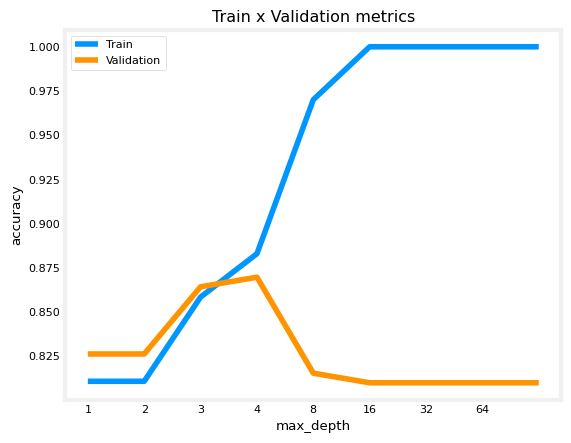

In [15]:
plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

We can see that in general, reducing `max_depth` can help to reduce overfitting.
- Reducing `max_depth` from 8 to 4 increases validation accuracy closer to training accuracy, while significantly reducing training accuracy.
- The validation accuracy reaches the highest at tree_depth=4. 
- When the `max_depth` is smaller than 3, both training and validation accuracy decreases.  The tree cannot make enough splits to distinguish positives from negatives (the model is underfitting the training set). 
- When the `max_depth` is too high ( >= 5), validation accuracy decreases while training accuracy increases, indicating that the model is overfitting to the training set.

So we can choose the best values for these two hyper-parameters for our model to be:
- `max_depth = 4`
- `min_samples_split = 50` 

In [16]:
decision_tree_model = DecisionTreeClassifier(min_samples_split = 50,
                                             max_depth = 3,
                                             random_state = RANDOM_STATE).fit(X_train,y_train)

In [17]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.8583
Metrics validation:
	Accuracy score: 0.8641


No sign of overfitting, even though the metrics are not that good.

## 4.2 Random Forest

Now let's try the Random Forest algorithm also, using the Scikit-learn implementation. 
- All of the hyperparameters found in the decision tree model will also exist in this algorithm, since a random forest is an ensemble of many Decision Trees.
- One additional hyperparameter for Random Forest is called `n_estimators` which is the number of Decision Trees that make up the Random Forest. 

Remember that for a Random Forest, we randomly choose a subset of the features AND randomly choose a subset of the training examples to train each individual tree.
- If $n$ is the number of features, we will randomly select $\sqrt{n}$ of these features to train each individual tree. 
- Note that you can modify this by setting the `max_features` parameter.

You can also speed up your training jobs with another parameter, `n_jobs`. 
- Since the fitting of each tree is independent of each other, it is possible fit more than one tree in parallel. 
- So setting `n_jobs` higher will increase how many CPU cores it will use. Note that the numbers very close to the maximum cores of your CPU may impact on the overall performance of your PC and even lead to freezes. 
- Changing this parameter does not impact on the final result but can reduce the training time.

We will run the same script again, but with another parameter, `n_estimators`, where we will choose between 10, 50, and 100. The default is 100.

In [18]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]  ## If the number is an integer, then it is the actual quantity of samples,
                                             ## If it is a float, then it is the percentage of the dataset
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]

Text(0.5, 1.0, 'Train x Validation metrics')

Text(0.5, 0, 'min_samples_split')

Text(0, 0.5, 'accuracy')

([<matplotlib.axis.XTick at 0x7e126d8c5870>,
 [Text(0, 0, '2'),
  Text(1, 0, '10'),
  Text(2, 0, '30'),
  Text(3, 0, '50'),
  Text(4, 0, '100'),
  Text(5, 0, '200'),
  Text(6, 0, '300'),
  Text(7, 0, '700')])

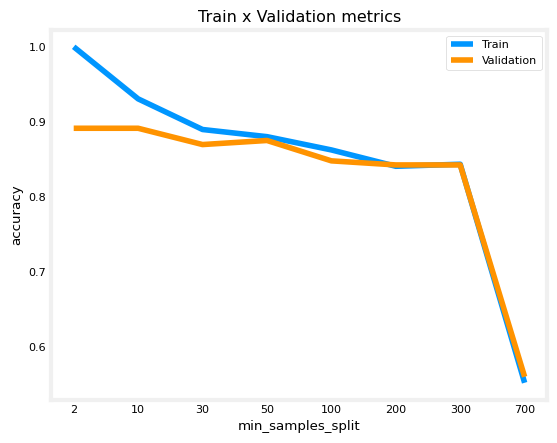

In [19]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

Notice that, even though the validation accuraty reaches is the same both at `min_samples_split = 2` and `min_samples_split = 10`, in the latter the difference in training and validation set reduces, showing less overfitting.

Text(0.5, 1.0, 'Train x Validation metrics')

Text(0.5, 0, 'max_depth')

Text(0, 0.5, 'accuracy')

([<matplotlib.axis.XTick at 0x7e126fa3ab90>,
 [Text(0, 0, '2'),
  Text(1, 0, '4'),
  Text(2, 0, '8'),
  Text(3, 0, '16'),
  Text(4, 0, '32'),
  Text(5, 0, '64'),
  Text(6, 0, '')])

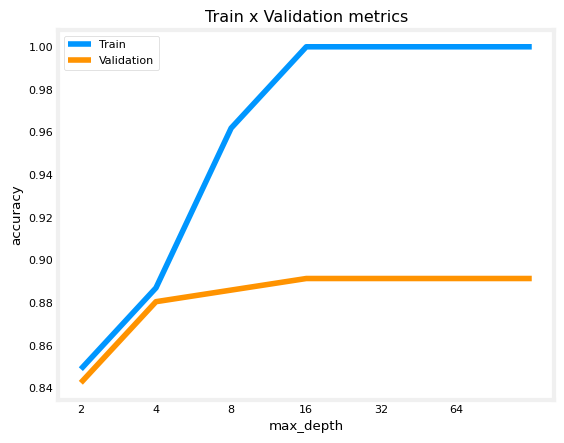

In [20]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

Text(0.5, 1.0, 'Train x Validation metrics')

Text(0.5, 0, 'n_estimators')

Text(0, 0.5, 'accuracy')

([<matplotlib.axis.XTick at 0x7e126d7f56f0>,
 [Text(0, 0, '10'), Text(1, 0, '50'), Text(2, 0, '100'), Text(3, 0, '500')])

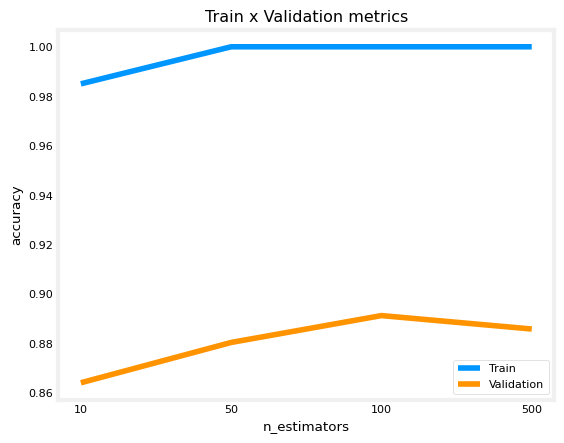

In [21]:
accuracy_list_train = []
accuracy_list_val = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(n_estimators = n_estimators,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

Let's then fit a random forest with the following parameters:

 - max_depth: 16
 - min_samples_split: 10
 - n_estimators: 100

In [22]:
random_forest_model = RandomForestClassifier(n_estimators = 100,
                                             max_depth = 16, 
                                             min_samples_split = 10).fit(X_train,y_train)

In [23]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9292
Metrics test:
	Accuracy score: 0.8913


Note that we are searching for the best value one hyperparameter while leaving the other hyperparameters at their default values.
- Ideally, we would want to check every combination of values for every hyperparameter that we are tuning.
- If we have 3 hyperparameters, and each hyperparameter has 4 values to try out, we should have a total of 4 x 4 x 4 = 64 combinations to try.
- When we only modify one hyperparameter while leaving the rest as their default value, we are trying 4 + 4 + 4 = 12 results. 
- To try out all combinations, we can use a sklearn implementation called GridSearchCV. GridSearchCV has a refit parameter that will automatically refit a model on the best combination so we will not need to program it explicitly. For more on GridSearchCV, please refer to its [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

## 4.3 XGBoost

Next is the Gradient Boosting model, called XGBoost. The boosting methods train several trees, but instead of them being uncorrelated to each other, now the trees are fit one after the other in order to minimize the error. 

The model has the same parameters as a decision tree, plus the learning rate.
- The learning rate is the size of the step on the Gradient Descent method that the XGBoost uses internally to minimize the error on each train step.

One interesting thing about the XGBoost is that during fitting, it can take in an evaluation dataset of the form `(X_val,y_val)`.
- On each iteration, it measures the cost (or evaluation metric) on the evaluation datasets.
- Once the cost (or metric) stops decreasing for a number of rounds (called early_stopping_rounds), the training will stop. 
- More iterations lead to more estimators, and more estimators can result in overfitting.  
- By stopping once the validation metric no longer improves, we can limit the number of estimators created, and reduce overfitting.

First, let's define a subset of our training set (we should not use the test set here).

In [24]:
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval


In [25]:
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

We can then set a large number of estimators, because we can stop if the cost function stops decreasing.

Note some of the `.fit()` parameters:
- `eval_set = [(X_train_eval,y_train_eval)]`:Here we must pass a list to the eval_set, because you can have several different tuples ov eval sets. 
- `early_stopping_rounds`: This parameter helps to stop the model training if its evaluation metric is no longer improving on the validation set. It's set to 10.
  - The model keeps track of the round with the best performance (lowest evaluation metric).  For example, let's say round 16 has the lowest evaluation metric so far.
  - Each successive round's evaluation metric is compared to the best metric.  If the model goes 10 rounds where none have a better metric than the best one, then the model stops training.
  - The model is returned at its last state when training terminated, not its state during the best round.  For example, if the model stops at round 26, but the best round was 16, the model's training state at round 26 is returned, not round 16.
  - Note that this is different from returning the model's "best" state (from when the evaluation metric was the lowest).

In [26]:
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, random_state = RANDOM_STATE)
xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)], early_stopping_rounds = 10)

[0]	validation_0-logloss:0.63302
[1]	validation_0-logloss:0.59554
[2]	validation_0-logloss:0.56614
[3]	validation_0-logloss:0.54187
[4]	validation_0-logloss:0.52349
[5]	validation_0-logloss:0.50611
[6]	validation_0-logloss:0.49373
[7]	validation_0-logloss:0.48366
[8]	validation_0-logloss:0.47323
[9]	validation_0-logloss:0.46538
[10]	validation_0-logloss:0.46000
[11]	validation_0-logloss:0.45621
[12]	validation_0-logloss:0.45483
[13]	validation_0-logloss:0.44975
[14]	validation_0-logloss:0.44495
[15]	validation_0-logloss:0.44073
[16]	validation_0-logloss:0.44078
[17]	validation_0-logloss:0.43936
[18]	validation_0-logloss:0.44206
[19]	validation_0-logloss:0.44536
[20]	validation_0-logloss:0.44322
[21]	validation_0-logloss:0.44310
[22]	validation_0-logloss:0.44419
[23]	validation_0-logloss:0.44797


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.44843
[25]	validation_0-logloss:0.45337
[26]	validation_0-logloss:0.45206


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=55, ...)

Even though we initialized the model to allow up to 500 estimators, the algorithm only fit 26 estimators (over 26 rounds of training).

To see why, let's look for the round of training that had the best performance (lowest evaluation metric).  You can either view the validation log loss metrics that were output above, or view the model's `.best_iteration` attribute:

In [27]:
xgb_model.best_iteration

17

The best round of training was round 17, with a log loss of 4.3936.  
- For 10 rounds of training after that (from round 18 to 27), the log loss was higher than this.
- Since we set `early_stopping_rounds` to 10, then by the 10th round where the log loss doesn't improve upon the best one, training stops.
- You can try out different values of `early_stopping_rounds` to verify this.  If you set it to 20, for instance, the model stops training at round 37 (17 + 20).

In [28]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9319
Metrics test:
	Accuracy score: 0.8533


In this example, both Random Forest and XGBoost had similar performance (test accuracy).  

Here, you have learned how to use Decision Tree, Random Forest from the scikit-learn library and XGBoost!